In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# from tqdm.autonotebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pyproj
import seaborn as sns

from scipy.stats import linregress, gaussian_kde
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf

import skgstat as skg
from pylr2 import regress2

### 1. Read in data

In [2]:
df = pd.read_feather('/maps/forecol/data/Overlays/monte_carlo_no_spatial_autocorr/results/nonan/master_summary.feather')

l4a_data = df
l4a_data['agcd'] = l4a_data.agbd * 0.47
l4a_data['recovery_period'] = l4a_data.mode_vals
quality_gedi = l4a_data

In [4]:
quality_gedi_gdf = gpd.GeoDataFrame(quality_gedi, geometry=gpd.points_from_xy(quality_gedi.lon_lowestmode, quality_gedi.lat_lowestmode))

In [5]:
# Test: point recovery rate 
quality_gedi_gdf['recovery_rate'] = quality_gedi_gdf['agcd'] / quality_gedi_gdf['recovery_period']

In [49]:
# Test: try some spatial autocorrelation filtering and see how it goes ..
import src.utils.hexagons as hex
pts = quality_gedi_gdf

# 1. Label the points with the hexagon that contains them
diameter = 1000
sa_albers = pyproj.CRS.from_string("ESRI:102033")
pts = pts.to_crs(sa_albers)
pts['label'] = hex.pair_to_label(*hex.xy_to_axial(pts.geometry.x, pts.geometry.y, diameter=diameter))

# 2. Group the points by hexagon and pick one random point from each hexagon
rng = np.random.default_rng()
sample = pts.groupby('label').agg(rng.choice)

print(len(sample))

41156


In [55]:
quality_gedi.to_csv('/home/ah2174/test/export-gedi-results.csv')

In [45]:
print(sample.geometry)

label
7792.0       POINT (791571.616 2159126.094)
7796.0       POINT (859210.962 2203532.128)
8140.0       POINT (668471.766 2132139.815)
8142.0       POINT (713954.281 2144795.958)
8144.0       POINT (715048.716 2152226.327)
                         ...               
62609.0    POINT (-1839300.104 3742201.447)
62613.0    POINT (-1883631.021 3713237.788)
63599.0    POINT (-1592239.477 3912239.283)
63603.0    POINT (-1655975.989 3885259.098)
64611.0    POINT (-1589383.653 3954134.229)
Name: geometry, Length: 3021, dtype: geometry


In [50]:
quality_gedi_gdf_sample = gpd.GeoDataFrame(sample, crs=sa_albers).to_crs('EPSG:4326')

### 2. Basic data filtering

167856


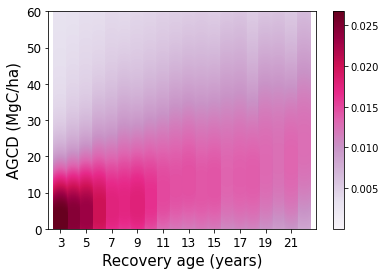

In [3]:
qg = quality_gedi

n = len(qg)
print(n)
# sample = np.random.choice(n, size=int(n/5), replace=False)
# x = qg.recovery_period.iloc[sample].values
# y = qg.agbd.iloc[sample].values

x = qg.recovery_period.values
y = qg.agcd.values

# Calculate the point density distribution per age group
ages = np.unique(x)
z = np.zeros(y.shape)
for i in ages:
    z[x == i] = gaussian_kde(y[x == i])(y[x == i])


# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# limit to only the points with high enough density
# x = x[z > 0.005]
# y = y[z > 0.005]
# z = z[z > 0.005]

fig, ax = plt.subplots()
im = ax.scatter(x, y, c=z, s=150, cmap='PuRd')
ax.set_ylim([0,60])
ax.set_xticks(ages[::2])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Recovery age (years)", size=15)
ax.set_ylabel("AGCD (MgC/ha)", size=15)
plt.colorbar(im)

plt.show()

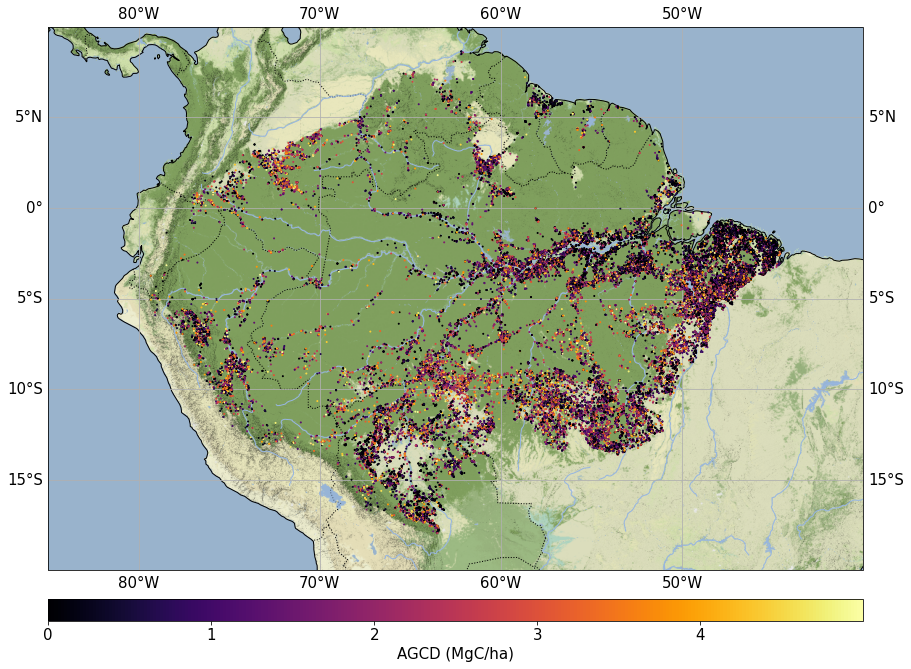

In [12]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -40, -20, 10], crs=ccrs.PlateCarree())

# Background: Stamen terrain with added Cartopy features
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add the colorbar axes anywhere in the figure. Its position will be
# re-calculated after the main plot is drawn
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
cbar_orientation = "horizontal"
cbar_width = 0.03

# Plot our data
not_outliers = quality_gedi_gdf[(quality_gedi_gdf.recovery_rate < 5)]
not_outliers.plot(column='recovery_rate', zorder=10, markersize=1, ax=ax, cmap='inferno', legend=True, legend_kwds={"orientation": cbar_orientation, "label": "AGCD (MgC/ha)"}, cax=cbar_ax)

## Find the location of the main plot axes now that the plot has been drawn, and stick our colorbar there.
posn = ax.get_position()
if cbar_orientation == "vertical":
    cbar_ax.set_position([posn.x0+posn.width+0.05, posn.y0, cbar_width, posn.height])
    cbar_ax.tick_params(axis="y", which="major", labelsize=15)
    cbar_ax.yaxis.label.set_size(15)
if cbar_orientation == "horizontal":
    cbar_ax.set_position([posn.x0, posn.y0-0.07, posn.width, cbar_width])
    cbar_ax.tick_params(axis="x", which="major", labelsize=15)
    cbar_ax.xaxis.label.set_size(15)

# Longitude and latitude degrees on the axes
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

plt.show()

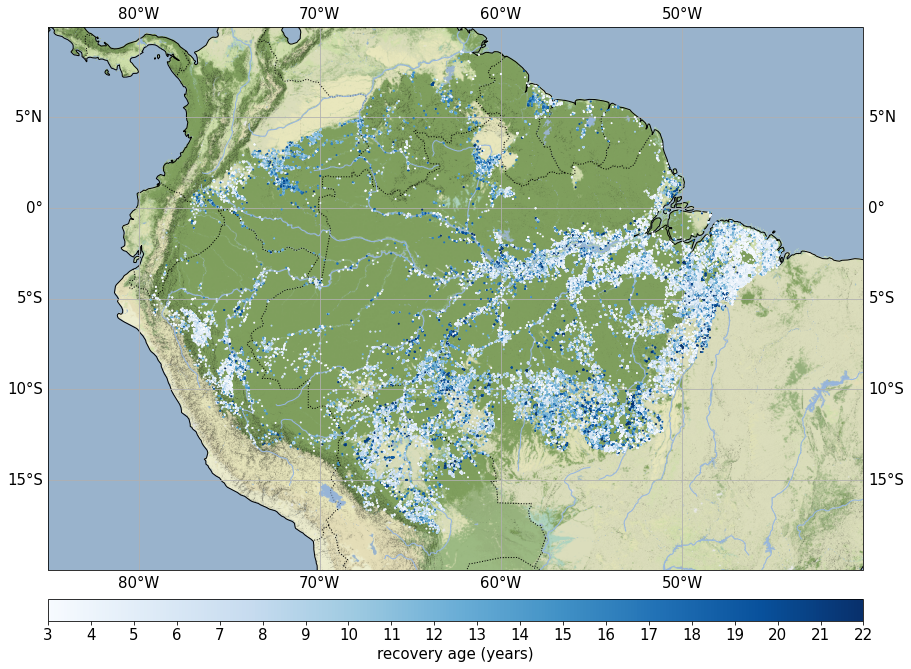

In [77]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -40, -20, 10], crs=ccrs.PlateCarree())

# Background: Stamen terrain with added Cartopy features
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add the colorbar axes anywhere in the figure. Its position will be
# re-calculated after the main plot is drawn
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
cbar_orientation = "horizontal"
cbar_width = 0.03

# Plot our data
not_outliers = quality_gedi_gdf[quality_gedi_gdf.agcd < 120]
max_age = int(not_outliers.recovery_period.max())
not_outliers.plot(
    column='recovery_period', zorder=10, markersize=1, ax=ax, cmap='Blues', 
    legend=True, legend_kwds={
        "orientation": cbar_orientation, 
        "label": "recovery age (years)", 
        "ticks": list(range(max_age + 1))
    }, cax=cbar_ax
)

## Find the location of the main plot axes now that the plot has been drawn, and stick our colorbar there.
posn = ax.get_position()
if cbar_orientation == "vertical":
    cbar_ax.set_position([posn.x0+posn.width+0.05, posn.y0, cbar_width, posn.height])
    cbar_ax.tick_params(axis="y", which="major", labelsize=15)
    cbar_ax.yaxis.label.set_size(15)
if cbar_orientation == "horizontal":
    cbar_ax.set_position([posn.x0, posn.y0-0.07, posn.width, cbar_width])
    cbar_ax.tick_params(axis="x", which="major", labelsize=15)
    cbar_ax.xaxis.label.set_size(15)

# Longitude and latitude degrees on the axes
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

plt.show()

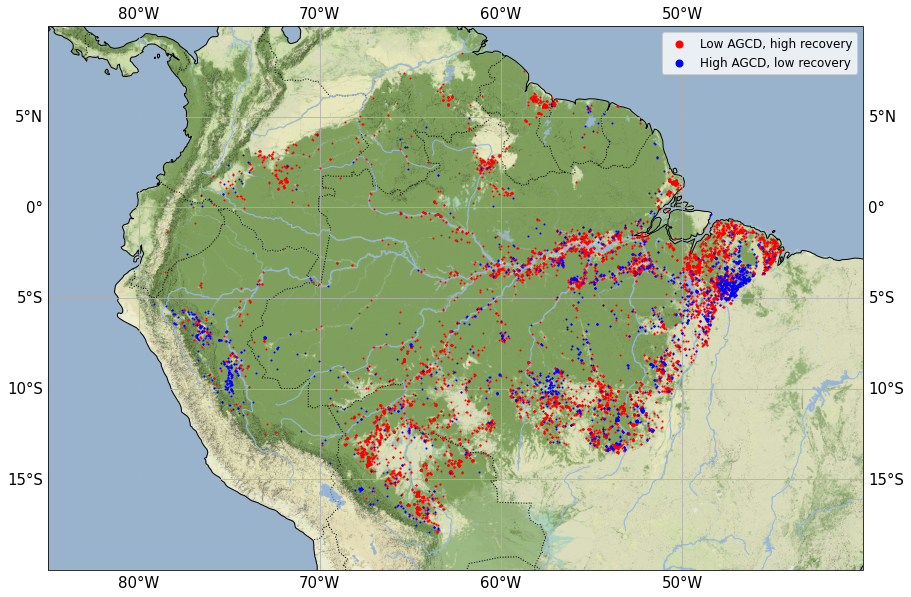

In [61]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -40, -20, 10], crs=ccrs.PlateCarree())

# Background: Stamen terrain with added Cartopy features
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot our data
low = quality_gedi_gdf[(quality_gedi_gdf.agcd < 1) & (quality_gedi_gdf.recovery_period > 5)]
high = quality_gedi_gdf[(quality_gedi_gdf.agcd > 100) & (quality_gedi_gdf.recovery_period < 4)]
low.plot(color="red", zorder=10, markersize=1, ax=ax)
high.plot(color="blue", zorder=10, markersize=1, ax=ax)

# Longitude and latitude degrees on the axes
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

plt.legend(["Low AGCD, high recovery", "High AGCD, low recovery"], loc=0, frameon=True, fontsize="large", markerscale=7)

plt.show()

In [28]:
low_count = len(quality_gedi[(quality_gedi.agcd < 1) & (quality_gedi.recovery_period > 5)])
low_pct = low_count/len(quality_gedi)

high_count = len(quality_gedi[(quality_gedi.agcd > 100) & (quality_gedi.recovery_period < 4)])
high_pct = high_count / len(quality_gedi)

print("Unlikely zeros:")
print("{} ({} %)".format(low_count, low_pct))
print("Unlikely extreme highs:")
print("{} ({} %)".format(high_count, high_pct))

Unlikely zeros:
8535 (0.07466015850522227 %)
Unlikely extreme highs:
2408 (0.021064049406042794 %)


### 3a. Modeling: Quantile Regression

In [20]:
qreg_model = pd.read_feather('/maps/forecol/data/Overlays/monte_carlo_no_spatial_autocorr/results/std1/model_results_p100.feather')


### 3b. Modeling: Linear Regression

### 4. Graphs

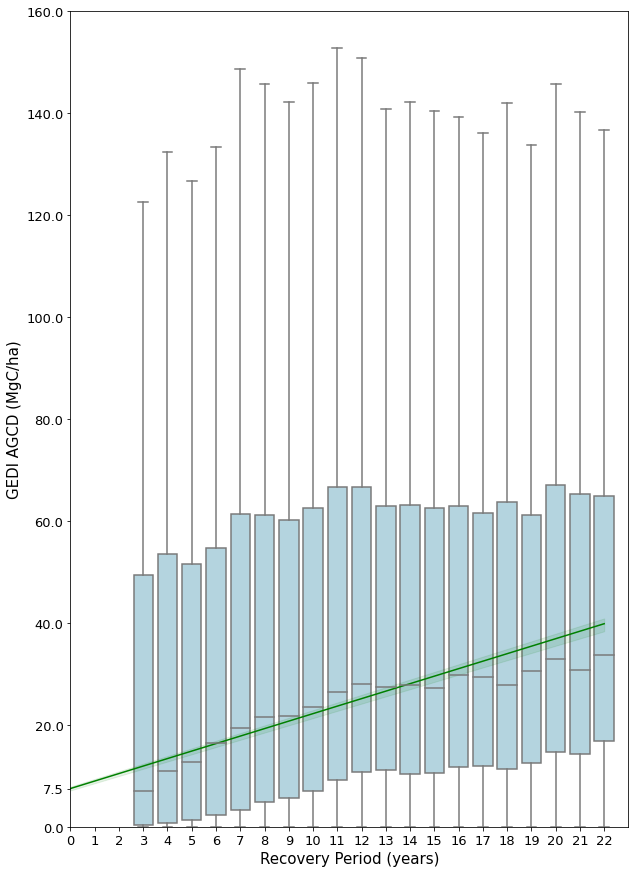

In [5]:
plt.figure(1, (10,15))
ax = sns.boxplot(x="recovery_period", y="agcd", data=quality_gedi, color='lightblue', showfliers=False, order=np.arange(23))
ax.set_ylabel("GEDI AGCD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,23])
xs = np.arange(0, 23)

# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
# for i in range(0,models.shape[0], 10):
#     ys = get_ys(models.a[i], models.b[i])
#     ax.plot(xs, ys, linestyle="dotted", color=cmap(i), label='Quantile {0:.2f}'.format(models.q[i]))
def get_ys_ci(la, lb, ua, ub):
    return (la + lb * xs, ua + ub * xs)

# Specify model params manually:
a = 7.51
la = 7.13
ua = 7.89
b = 1.47
lb = 1.42
ub = 1.50

# Or else use the qreg model above
# a = qreg_model.a.mean()
# b = qreg_model.b.mean()
# la = qreg_model.la.quantile(0.025)
# ua = qreg_model.ua.quantile(0.975)
# lb = qreg_model.lb.quantile(0.025) 
# ub = qreg_model.ub.quantile(0.975)

med_ys = get_ys(a,b)
lower_ys, upper_ys = get_ys_ci(la, lb, ua, ub)
ax.plot(xs, med_ys, color="green")
ax.fill_between(xs, lower_ys, upper_ys, color="green", alpha=0.1)
ax.set_ylim([0, 150])
# Add y-intercept to y-ticks:
yticks = list(ax.get_yticks()[ax.get_yticks() >= 0])
yticks.append(a)
yticks.sort()
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=13)


114318


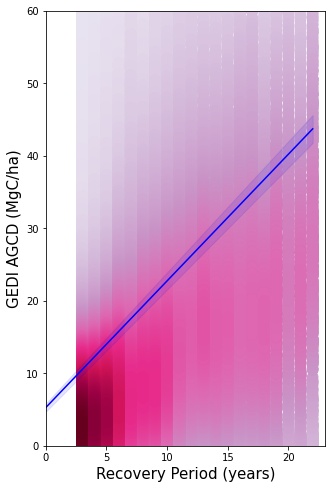

In [20]:
fig, ax = plt.subplots(1, figsize=(5,8))

qg = quality_gedi
n = len(qg)
print(n)
# sample = np.random.choice(n, size=int(n/5), replace=False)
# x = qg.recovery_period.iloc[sample].values
# y = qg.agbd.iloc[sample].values

x = qg.recovery_period.values
y = qg.agcd.values

# Calculate the point density distribution per age group
ages = np.unique(x)
z = np.zeros(y.shape)
for i in ages:
    z[x == i] = gaussian_kde(y[x == i])(y[x == i])


# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# limit to only the points with high enough density
# x = x[z > 0.005]
# y = y[z > 0.005]
# z = z[z > 0.005]

ax.scatter(x, y, c=z, s=110, cmap='PuRd')
ax.set_ylim([0,60])

xs = np.arange(0, 23)
get_ys = lambda a, b: a + b * xs
def get_ys_ci(la, lb, ua, ub):
    return (la + lb * xs, ua + ub * xs)


med_ys = get_ys(qreg_model.a.mean(), qreg_model.b.mean())
lower_ys, upper_ys = get_ys_ci(qreg_model.la.quantile(0.025), qreg_model.lb.quantile(0.025), qreg_model.ua.quantile(0.975), qreg_model.ub.quantile(0.975))
ax.plot(xs, med_ys, color="blue")
ax.fill_between(xs, lower_ys, upper_ys, color="blue", alpha=0.1)
ax.set_ylabel("GEDI AGCD (MgC/ha)", fontsize=15)
ax.set_xlabel("Recovery Period (years)", fontsize=15)
ax.set_xlim([0,23])
plt.show()

### 5. Cross-validation

In [9]:
# K-fold cross-validation for the median quantile regression line
# Returns array of error results on each split.

def check_function(q, ys, predictions):
    abs_err = (ys - predictions).abs()
    penalty_under = (q * abs_err[predictions <= ys]).sum()
    penalty_over = ((1 - q) * abs_err[predictions > ys]).sum()
    return (penalty_under + penalty_over) / len(ys)

def compute_qreg_error(model, q, data, predictor, response):
    a = qreg_model.a.mean()
    b = qreg_model.b.mean()
    predictions = a + b * data[predictor]
    return check_function(q, data[response], predictions) 


def cross_validate_qregression(
    q: float, n_splits: int, data: pd.DataFrame, predictor: str, response: str):
    kf = KFold(n_splits=n_splits, shuffle=True)
    qregs = []
    for train_index, test_index in kf.split(data):
        train = data.iloc[train_index].loc[:, [predictor, response]]
        test =  data.iloc[test_index][[predictor, response]]

        mod = smf.quantreg(response + ' ~ ' + predictor, train)
        model = mod.fit(q=q)

        qregs.append(compute_qreg_error(model, q, test, predictor, response))

    return np.array(qregs)

In [15]:
qregs = cross_validate_qregression(
    q=0.5,
    n_splits=10,
    data=quality_gedi,
    predictor='recovery_period',
    response='agcd'
)
print(qregs)
print(qregs.mean())


[17.86432107 17.86546106 17.76588767 18.15463427 18.27124498 17.79916466
 18.6448263  18.00901487 18.16607486 17.5857566 ]
18.01263863425398


In [16]:
# Add column of residuals to dataframe
q=0.5
mod = smf.quantreg('agcd ~ recovery_period', quality_gedi)
median_model = mod.fit(q=q)

predictions = median_model.params['Intercept'] + median_model.params['recovery_period'] * quality_gedi['recovery_period']
quality_gedi['median_error'] = predictions - quality_gedi['agcd']

abs_err = quality_gedi.median_error.abs()
quality_gedi['median_qreg_error'] = np.zeros_like(abs_err)
quality_gedi.loc[quality_gedi.median_error <= 0, 'median_qreg_error']  = q * abs_err[quality_gedi.median_error <= 0]
quality_gedi.loc[quality_gedi.median_error > 0, 'median_qreg_error'] = (1 - q) * abs_err[quality_gedi.median_error > 0]

count    1.143180e+05
mean    -2.416612e+01
std      6.108753e+01
min     -1.529112e+03
25%     -3.901917e+01
50%      3.730979e-07
75%      1.011004e+01
max      4.439337e+01
Name: median_error, dtype: float64
count    1.143180e+05
mean     1.799886e+01
std      2.747656e+01
min      6.671861e-08
25%      4.108247e+00
50%      7.178198e+00
75%      1.999040e+01
max      7.645562e+02
Name: median_qreg_error, dtype: float64


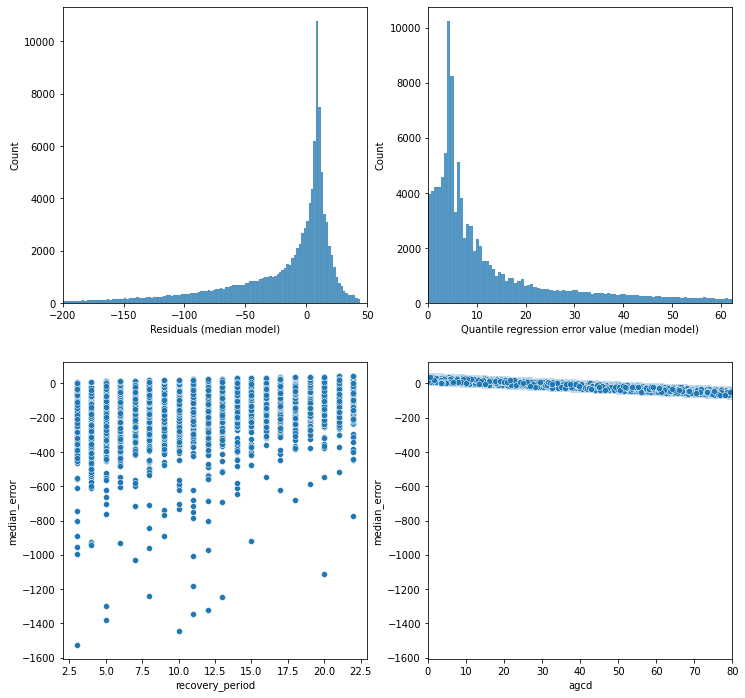

In [33]:
# Plot model residuals (histogram)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
sns.histplot(quality_gedi, x='median_error', ax=axs[0, 0])
axs[0, 0].set_xlim(-200, 50)
axs[0, 0].set_xlabel('Residuals (median model)')
sns.histplot(quality_gedi, x='median_qreg_error', ax=axs[0, 1])
axs[0, 1].set_xlim(0, 8.2 + 12.3 * 4.4)
axs[0, 1].set_xlabel('Quantile regression error value (median model)')
sns.scatterplot(data=quality_gedi, x='recovery_period', y='median_error', ax=axs[1,0])
sns.scatterplot(data=quality_gedi, x='agcd', y='median_error', ax=axs[1,1])
axs[1,1].set_xlim(0,80)
print(quality_gedi.median_error.describe())
print(quality_gedi.median_qreg_error.describe())


### 6. Spatial (Auto)correlation

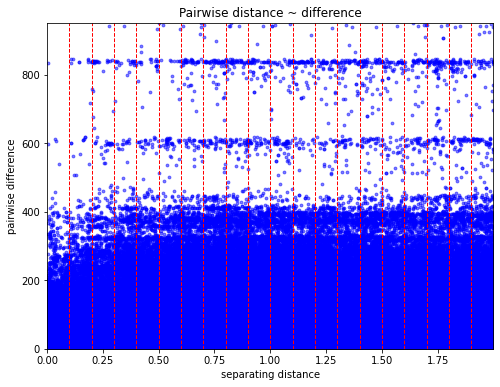

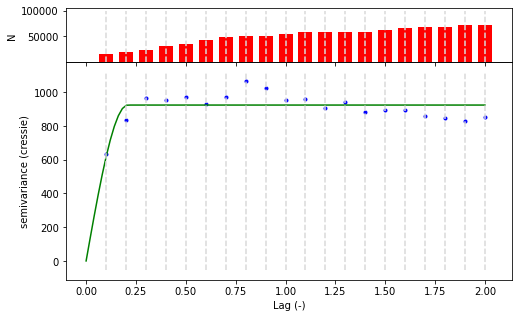

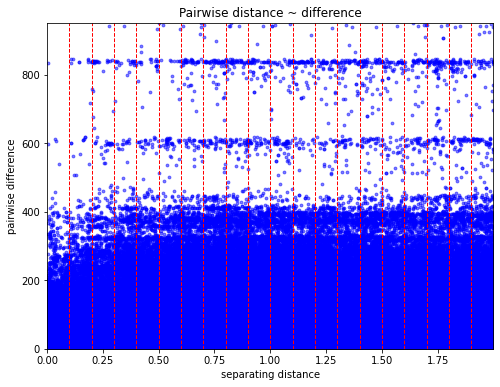

In [53]:
# Plot variogram based on residuals
# Sample a random selection of data points
k = 20      # Randomly sample 1/k th of the points
np.random.seed(42)
idxs = np.random.randint(0, len(quality_gedi), (int(len(quality_gedi) / k)))
#coords = np.column_stack([quality_gedi_gdf.iloc[idxs].geometry.x, quality_gedi_gdf.iloc[idxs].geometry.y])
coords = quality_gedi.iloc[idxs][['lon_lowestmode', 'lat_lowestmode']].to_numpy()
values = quality_gedi.iloc[idxs]['median_error'].abs().to_numpy()
V = skg.Variogram(
    coords,         # Spatial coordinates
    values,         # Residuals
    maxlag=2,       # Maximum distance (in lon, lat degrees) between data points to consider
    n_lags=20,
)
V.estimator = 'cressie'
V.plot()
V.distance_difference_plot()